In [2]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib

import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import xarray as xr

from boutdata.restart import addvar
import glob
import shutil
import scipy
import netCDF4 as nc

sys.path.append(r"/home/mike/work/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.neutral_transport import NeutralTransport
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.balance1d import *
# from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2

# Could not successfully reproduce Vperp

In [2]:
db = CaseDB(
    case_dir = r"/home/mike/work/cases",
    grid_dir = r"/home/mike/work/cases"
    )

In [3]:
toload = [ 
    dict(name="base", id="upst3b-E-neutral-adv_fluxlim1", unnormalise = False), 
    dict(name="si", id="upst3b-E-neutral-adv_fluxlim1", unnormalise = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = False, verbose = True, unnormalise = case["unnormalise"], unnormalise_geom = case["unnormalise"])
    cs[case["name"]].extract_2d_tokamak_geometry()


- Reading case upst3b-E-neutral-adv_fluxlim1
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



- Reading case upst3b-E-neutral-adv_fluxlim1
-----------------------


/home/mike/work/xbout/xbout/load.py:1129: UserWarning: Will drop all variables containing the dimensions 't' because they are not recognised
  warn(



Unnormalising with xHermes


# Get data

In [ ]:
dfs = {}

for name in ["base", "si"]:
    ds = cs[name].ds
    if "t" in ds.sizes: ds = ds.isel(t=-1)
    dfs[name] = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "g22", "g_33", "Nd", "Ne", "Pd", "Dnnd", "Td", "particle_flux_factor_d", "Vd_perp_x", "Vd_perp_ddx", "gradlogP"], "omp")


NameError: name 'cs' is not defined

# Dnn check

## Norm: check gradP

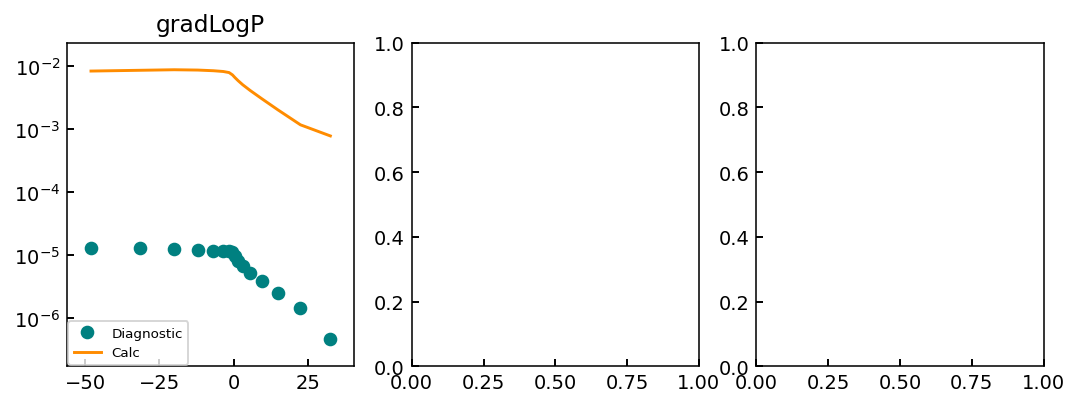

In [16]:
name = "base"
hrdf = dfs[name]
ds = cs[name].ds

m = ds.metadata
Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

pn_floor = 1e-8 * 1/100 * Pnorm
hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

hrdf["gradlogP_calc"] = np.gradient(np.log(hrdf["Pnlim"]), hrdf["Srad"])

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("gradLogP")

ax.plot(hrdf["Srad"], abs(hrdf["gradlogP"]), "o", label = "Diagnostic")
ax.plot(hrdf["Srad"], hrdf["gradlogP_calc"], label = "Calc")

ax.set_yscale("log")
ax.legend(fontsize = "x-small")

In [42]:
df = pd.DataFrame()

df["Srad_norm"] = dfs["base"]["Srad"]
df["Srad_si"] = dfs["si"]["Srad"]
df["Pnlim_norm"] = dfs["base"]["Pd"]
df["Pnlim_si"] = dfs["si"]["Pd"]

df["gradlogP_norm"] = np.gradient(np.log(dfs["base"]["Pd"]), dfs["base"]["Srad"])
df["gradlogP_si"] = np.gradient(np.log(dfs["si"]["Pd"]), dfs["si"]["Srad"])

print("Srad ratio:  ", (df["Srad_si"] / df["Srad_norm"]).values[0])
print("OK  rho_s0 = ", m["rho_s0"])
print()
print("Pd ratio:    ", (df["Pnlim_si"] / df["Pnlim_norm"]).values[0])
print("OK  Pnorm  = ", Pnorm)
print()
print("GradlogP ratio: ", (df["gradlogP_si"] / df["gradlogP_norm"]).values[0])
print("OK  1/rho_s0 =  ", 1/m["rho_s0"])
df

Srad ratio:   0.001021747755295248
OK  rho_s0 =  0.0010217477552952484

Pd ratio:     1.6021766339999999
OK  Pnorm  =  1.60217662

GradlogP ratio:  978.7151425755143
OK  1/rho_s0 =   978.7151425755136


,Srad_norm,Srad_si,Pnlim_norm,Pnlim_si,gradlogP_norm,gradlogP_si
0,-48.045121,-0.049090,0.091438,0.146499,0.008360,8.181794
1,-31.567422,-0.032254,0.104942,0.168135,0.008597,8.414063
2,-20.050860,-0.020487,0.116085,0.185989,0.008770,8.583153
3,-12.107372,-0.012371,0.124465,0.199415,0.008669,8.484688
4,-6.829119,-0.006978,0.130244,0.208675,0.008459,8.278520
5,-3.515262,-0.003592,0.133908,0.214544,0.008227,8.051452
6,-1.566698,-0.001601,0.136049,0.217975,0.007913,7.744780
7,-0.427994,-0.000437,0.137260,0.219914,0.007270,7.114940
8,0.427994,0.000437,0.138071,0.221214,0.006579,6.439225
9,1.456985,0.001489,0.138956,0.222633,0.005897,5.771836


In [13]:
hrdf["Pnlim"]

0     0.091438
1     0.104942
2     0.116085
3     0.124465
4     0.130244
5     0.133908
6     0.136049
7     0.137260
8     0.138071
9     0.138956
10    0.140157
11    0.141758
12    0.143666
13    0.145600
14    0.147231
15    0.148395
Name: Pnlim, dtype: float64

## Reproduce velocity from Dnn * grad(logP) (norm)

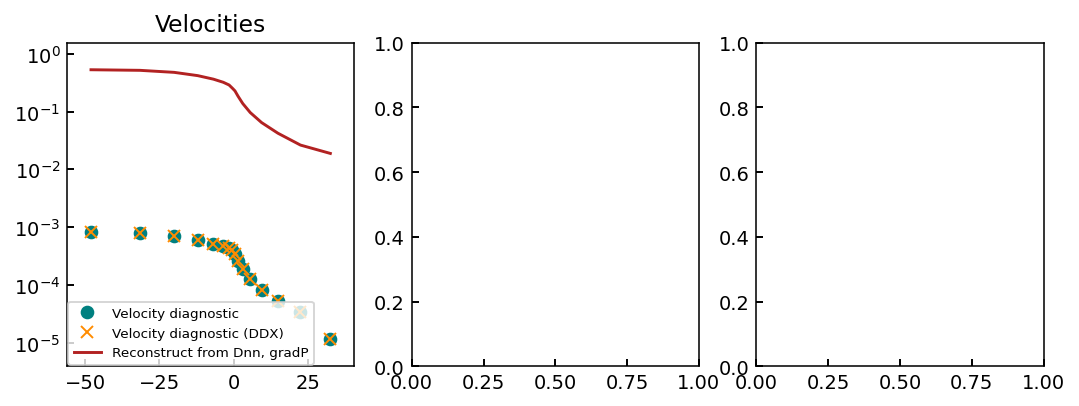

In [36]:
name = "base"
hrdf = dfs[name]
ds = cs[name].ds

m = ds.metadata
Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

pn_floor = 1e-8 * 1/100 * Pnorm
hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

hrdf["V_from_Dnn"] = -hrdf["Dnnd"] * np.gradient(np.log(hrdf["Pnlim"]), hrdf["Srad"]) 

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")

ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]), "o", label = "Velocity diagnostic")
ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_test"]), "x", label = "Velocity diagnostic (DDX)")
ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn"]), label = "Reconstruct from Dnn, gradP")

# ax.plot(hrdf["Srad"], hrdf["vth"], label = "Thermal speed")
ax.set_yscale("log")
ax.legend(fontsize = "x-small")

## Unnormalise and compare
Normalised Vperp to Cs0, which is equivalent to norms for Dnn * log(Pnlim).

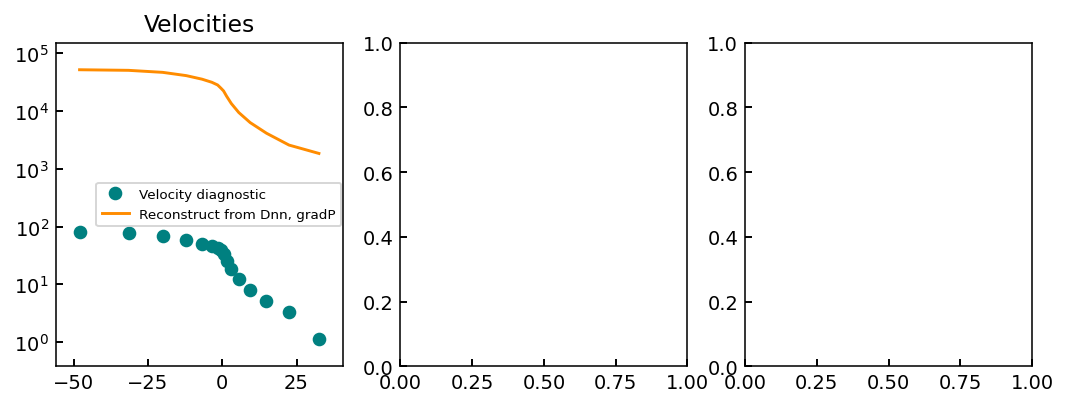

In [33]:
name = "base"
hrdf = dfs[name]
ds = cs[name].ds

m = ds.metadata
Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

pn_floor = 1e-8 * 1/100 * Pnorm
hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

hrdf["V_from_Dnn"] = -hrdf["Dnnd"] * np.gradient(np.log(hrdf["Pnlim"]), hrdf["Srad"]) 

Dnnd_si = hrdf["Dnnd"] * m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnlim_si = hrdf["Pnlim"] * Pnorm
Srad_si = hrdf["Srad"] * m["rho_s0"]
hrdf["V_from_Dnn_si"] = -Dnnd_si * np.gradient(np.log(Pnlim_si), Srad_si) 

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")

ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]) * m["Cs0"], "o", label = "Velocity diagnostic")
# ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_test"]), "x", label = "Velocity diagnostic (DDX)")
ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn_si"]), label = "Reconstruct from Dnn, gradP")

# ax.plot(hrdf["Srad"], hrdf["vth"], label = "Thermal speed")
ax.set_yscale("log")
ax.legend(fontsize = "x-small")

## Compare SI

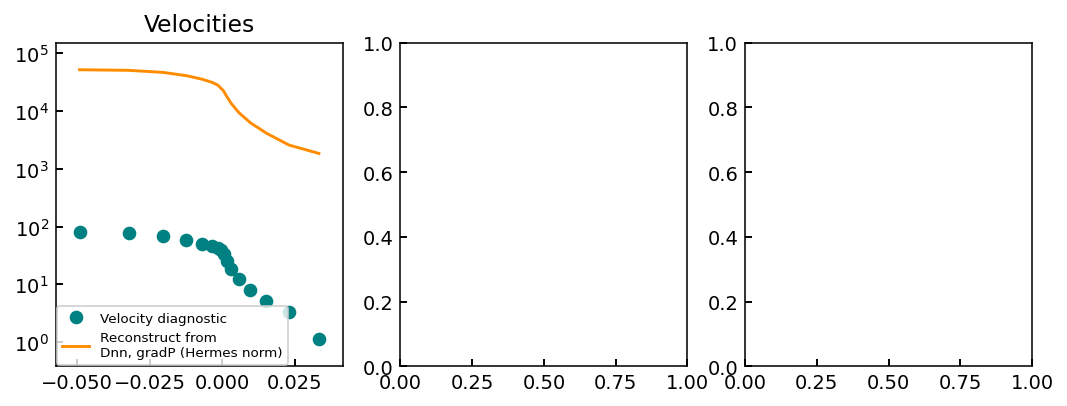

In [34]:
name = "si"
hrdf = dfs[name]
ds = cs[name].ds

m = ds.metadata
Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

pn_floor = 1e-8 * 1/100 * Pnorm
hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

hrdf["V_from_Dnn"] = -hrdf["Dnnd"] * np.gradient(np.log(hrdf["Pnlim"]), hrdf["Srad"]) 

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")

ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]), "o", label = "Velocity diagnostic")
ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn"]), label = "Reconstruct from \nDnn, gradP (Hermes norm)")

ax.set_yscale("log")
ax.legend(fontsize = "x-small")

## Start from SI and unnormalise

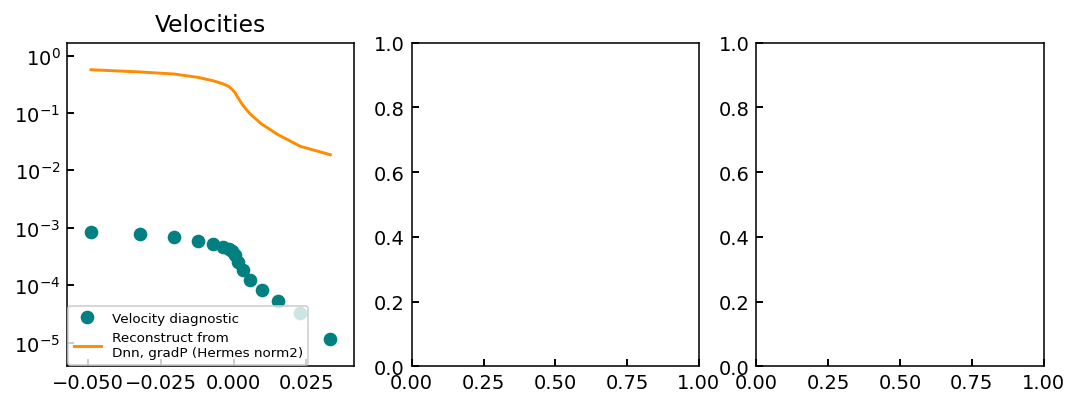

In [11]:
name = "si"
hrdf = dfs[name]
ds = cs[name].ds

m = ds.metadata
Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["rho_s0"]**3 * ds.metadata["Tnorm"] * constants("q_e")
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

pn_floor = 1e-8 * 1/100 * Pnorm
hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

hrdf["V_from_Dnn_si"] = -hrdf["Dnnd"] * np.gradient(np.log(hrdf["Pnlim"]), hrdf["Srad"]) 
# hrdf["V_from_Dnn_norm"] = -hrdf["Dnnd"]/Dnnorm * np.gradient(np.log(hrdf["Pnlim"]/Pnorm), hrdf["Srad"]/m["rho_s0"]) 

# hrdf["V_from_Dnn_norm"] = -hrdf["Dnnd"]/Dnnorm * 1/(hrdf["Pnlim"]/Pnorm) * np.gradient(hrdf["Pnlim"]/Pnorm, hrdf["Srad"]/m["rho_s0"])

hrdf["V_from_Dnn_norm2"] = -hrdf["Dnnd"] * 1/hrdf["Pnlim"] * np.gradient(hrdf["Pnlim"], hrdf["Srad"]) / (Dnnorm / m["rho_s0"])

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")

ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]) / m["Cs0"], "o", label = "Velocity diagnostic")
# ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn_norm"]), label = "Reconstruct from \nDnn, gradP (Hermes norm)")
ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn_norm2"]), label = "Reconstruct from \nDnn, gradP (Hermes norm2)")
# ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn_si"]), label = "Reconstruct from Dnn, gradP (manual norm)")

# ax.plot(hrdf["Srad"], hrdf["vth"], label = "Thermal speed")
ax.set_yscale("log")
ax.legend(fontsize = "x-small")

### Difference between SI and norm

In [29]:
norm = - dfs["base"]["Dnnd"] * 1/dfs["base"]["Pnlim"] * np.gradient(dfs["base"]["Pnlim"], dfs["base"]["Srad"]) 
si =   - dfs["si"]["Dnnd"] * 1/dfs["si"]["Pnlim"] * np.gradient(dfs["si"]["Pnlim"], dfs["si"]["Srad"]) 

print((si/norm)[0])
print(f"Should be: Cs0 = Dnnorm/rho_s0", " So: ", m["Cs0"], " = ", Dnnorm / m["rho_s0"])
print(f"Ratio: ", (si/norm)[0] / (Dnnorm / m["rho_s0"]) )
# print(f"This means it's exactly Cs0/Dnnorm off")
# print(f"This means the norm is Cs0^2 / Dnorm", m["Cs0"] * m["Cs0"] / Dnnorm)
# print(f"This is the same as Omega_ci: ", m["Omega_ci"])

97871.51425755145
Should be: Cs0 = Dnnorm/rho_s0  So:  97871.51425755137  =  97871.51425755137
Ratio:  1.0000000000000007


In [22]:
norm = - dfs["base"]["Dnnd"] * 1/dfs["base"]["Pnlim"] * dfs["base"]["Pnlim"]
si =   - dfs["si"]["Dnnd"] * 1/dfs["si"]["Pnlim"] * dfs["si"]["Pnlim"]

print((si/norm)[0])
# print(f"Should be: Cs0 = Dnnorm/rho_s0", " So: ", m["Cs0"], " = ", Dnnorm / m["rho_s0"])
# print(f"Ratio: ", (si/norm)[0] / (Dnnorm / m["rho_s0"]) )
# print(f"This means it's exactly Cs0/Dnnorm off")
# print(f"This means the norm is Cs0^2 / Dnorm", m["Cs0"] * m["Cs0"] / Dnnorm)
# print(f"This is the same as Omega_ci: ", m["Omega_ci"])

100.00000000000004


## It's the normalised dr that's wrong.

In [13]:
Dnconv = ds["Dnnd"].attrs["conversion"]
Pnconv = ds["Pd"].attrs["conversion"]

correct_norm = Dnconv * 1/Pnconv * (Pnconv / m["rho_s0"])
print(f"Norm should be = ", correct_norm)
# ds["Dnnd"].attrs["conversion"] / ds["dx"].attrs["conversion"]

Norm should be =  97871.51425755137


In [9]:
print("gradLogP norm: ", dfs["si"]["gradlogP"].values[0] / dfs["base"]["gradlogP"].values[0])
print("1/rho_s0: ", 1/m["rho_s0"])

gradLogP norm:  978.7151425755137
1/rho_s0:  978.7151425755136


In [28]:
print("Srad norm: ", dfs["si"]["Srad"].values[0] / dfs["base"]["Srad"].values[0])
# print("rho_s0: ", m["rho_s0"])

Srad norm:  0.001021747755295248


In [16]:
dxconv = ds["dx"].attrs["conversion"]
g11conv = ds["g11"].attrs["conversion"]

print("dxconv, g11conv: ", dxconv, g11conv)

print("dxconv / sqrt(g11conv), or rho_s0: ", dxconv / np.sqrt(g11conv), " = ", m["rho_s0"])



dxconv, g11conv:  1.0439684754508788e-06 1.0439684754508788e-06
dxconv / sqrt(g11conv), or rho_s0:  0.0010217477552952484  =  0.0010217477552952484


In [17]:
print("Implied dr norm: ", dfs["si"]["dr"].values[0] / dfs["base"]["dr"].values[0])

Implied dr norm:  0.0010217477552952482


In [25]:
df = pd.DataFrame()
df["dr"] = dfs["base"]["dr"]

## Calculate radial distance from separatrix
for i, _ in enumerate(df["dr"]):
    if i == 0:
        df.loc[i, "Srad"] = df.loc[i, "dr"] / 2
    else:
        df.loc[i, "Srad"] = df.loc[i-1, "Srad"] + df.loc[i-1, "dr"]/2 + df.loc[i, "dr"]/2
df["sep"] = 0
    
sepind = ds.metadata["ixseps1g"]
df.loc[sepind, "sep"] = 1
dfsep = df[df["sep"] == 1]

# Correct so 0 is inbetween the cell centres straddling separatrix
sepcorr = (df["Srad"][sepind] - df["Srad"][sepind-1]) / 2

df["Srad"] -= dfsep["Srad"].values - sepcorr
df["Srad_orig_norm"] = dfs["base"]["Srad"]

df

,dr,Srad,sep,Srad_orig_norm
0,19.390920,-48.045121,0,-48.045121
1,13.564477,-31.567422,0,-31.567422
2,9.468648,-20.050860,0,-20.050860
3,6.418328,-12.107372,0,-12.107372
4,4.138178,-6.829119,0,-6.829119
5,2.489535,-3.515262,0,-3.515262
6,1.407592,-1.566698,0,-1.566698
7,0.869816,-0.427994,0,-0.427994
8,0.842162,0.427994,1,0.427994
9,1.215819,1.456985,0,1.456985


Why does Srad norm not equal dr norm? 

In [60]:
print(ds["dx"].attrs["conversion"])
print(m["rho_s0"])

1.0439684754508788e-06
0.0010217477552952484


In [32]:
print(m["rho_s0"] / Dnnorm * m["Nnorm"]/m["rho_s0"]**3)
print(m["Cs0"])

9.578833303066078e+20
97871.51425755137


In [38]:
print(m["rho_s0"] * m["Omega_ci"])
print(m["Cs0"])

97871.51425755137
97871.51425755137


In [40]:
print(m["rho_s0"]**2 * m["Omega_ci"])
print(Dnnorm)

100.00000000000001
100.00000000000001


In [43]:
print(Dnnorm/m["rho_s0"])
print(m["Cs0"])

97871.51425755137
97871.51425755137


In [35]:
print(m["rho_s0"]**3)
print(m["Nnorm"])

1.066672446390938e-09
1e+17


In [ ]:
print("Dn")
print(ds["Dnnd"].attrs["conversion"])
print(Dnnorm)
print("Pd")
print(ds["Pd"].attrs["conversion"])
print(Pnorm)
print(f"L")
print(ds[""])

Dn
100.00000000000001
100.00000000000001
Pd
1.6021766339999999
1.60217662


## Reproduce velocity from flux (norm)

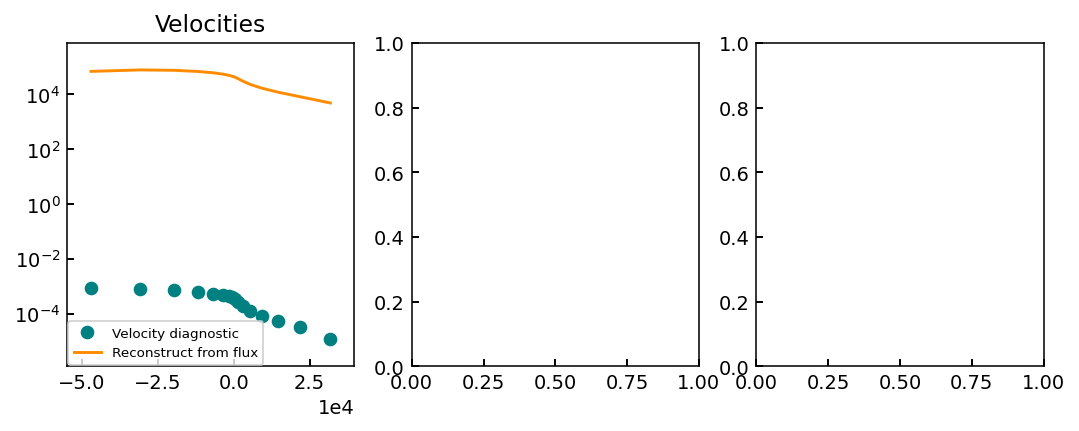

In [7]:
name = "base"
hrdf = dfs[name]
ds = cs[name].ds

m = ds.metadata
Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

pn_floor = 1e-8 * 1/100 * Pnorm
hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

## Calculate velocity from radial flux
hrdf["dpol"] = hrdf["dy"] * np.sqrt(hrdf["g22"])
hrdf["dtor"] = hrdf["dz"] * np.sqrt(hrdf["g_33"])
hrdf["da_radial"] = hrdf["dpol"] * hrdf["dtor"]
hrdf["flux_hermes"] = hrdf["ParticleFlow_d_xlow"] /  hrdf["da_radial"] * hrdf["particle_flux_factor_d"]
hrdf["V_from_flux"] = hrdf["flux_hermes"] / hrdf["Nd"] 

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")

ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]), "o", label = "Velocity diagnostic")
# ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_test"]), "x", label = "Velocity diagnostic (DDX)")
ax.plot(hrdf["Srad"], abs(hrdf["V_from_flux"]), label = "Reconstruct from flux")

# ax.plot(hrdf["Srad"], hrdf["vth"], label = "Thermal speed")
ax.set_yscale("log")
ax.legend(fontsize = "x-small")

In [14]:
hrdf["da_radial"]

0     3.012190
1     3.012406
2     3.009183
3     3.007452
4     3.006297
5     3.005573
6     3.005161
7     3.004925
8     3.004755
9     3.004557
10    3.004268
11    3.003870
12    3.003454
13    3.003350
14    3.005173
15    3.009420
Name: da_radial, dtype: float64

# Reproduce velocity
Correct is about 10^2

In [8]:
ds = cs["si"].ds
if "t" in ds.sizes: ds = ds.isel(t=-1)

hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "g22", "g_33", "Nd", "Ne", "Pd", "Dnnd", "Td", "particle_flux_factor_d", "Vd_perp_x", "Vd_perp_test"], "omp")


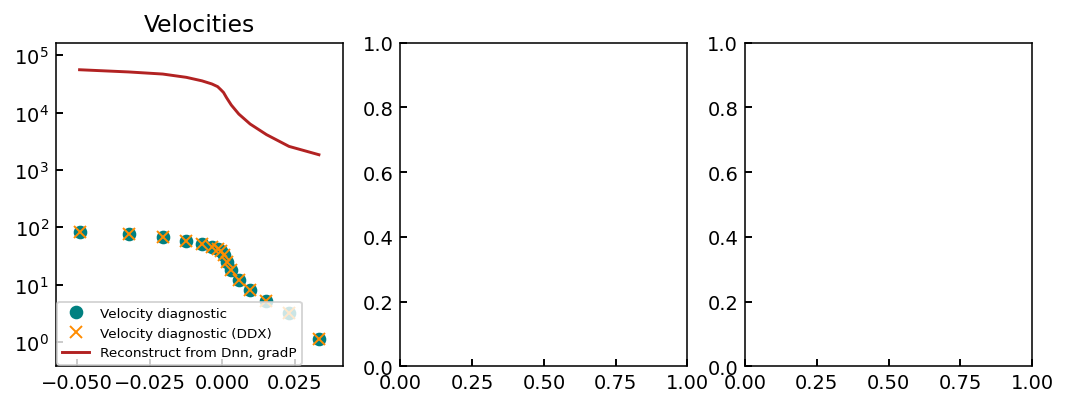

In [11]:
m = ds.metadata
Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

hrdf["dpol"] = hrdf["dy"] * np.sqrt(hrdf["g22"])
hrdf["dtor"] = hrdf["dz"] * np.sqrt(hrdf["g_33"])
hrdf["da_radial"] = hrdf["dpol"] * hrdf["dtor"]

pn_floor = 1e-8 * 1/100 * Pnorm
hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

hrdf["flux_hermes"] = hrdf["ParticleFlow_d_xlow"] /  hrdf["da_radial"] * hrdf["particle_flux_factor_d"]
hrdf["V_from_flux"] = hrdf["flux_hermes"] / hrdf["Nd"] 
# hrdf["V_from_Dnn"] = hrdf["Dnnd"] / (Dnnorm) #* np.gradient(np.log(hrdf["Pnlim"]))
# hrdf["V_from_Dnn"] = np.gradient(np.log(hrdf["Pnlim"] / Pnorm), hrdf["Srad"]/m["rho_s0"]) 
# hrdf["V_from_Dnn"] = -hrdf["Dnnd"]/Dnnorm * np.gradient(np.log(hrdf["Pnlim"] / Pnorm), hrdf["Srad"]/m["rho_s0"]) 

Dnnd_si = hrdf["Dnnd"] * m["Cs0"] * m["Cs0"] / m["Omega_ci"]
Pnlim_si = hrdf["Pnlim"] * Pnorm
Srad_si = hrdf["Srad"] * m["rho_s0"]


# hrdf["V_from_Dnn"] = -hrdf["Dnnd"] * np.gradient(np.log(hrdf["Pnlim"]), hrdf["Srad"]) 
hrdf["V_from_Dnn"] = -hrdf["Dnnd"] * 1/hrdf["Pd"] * np.gradient(hrdf["Pd"], hrdf["Srad"]) 

hrdf["V_from_Dnn_si"] = -Dnnd_si * np.gradient(np.log(Pnlim_si), Srad_si) 

# hrdf["Grad_Pa_hermes"] = np.gradient(hrdf["Pd"], hrdf["Srad"])
# hrdf["V_hermes_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"]
# hrdf["V_hermes_fluxlim_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"] * hrdf["particle_flux_factor_d"]
# hrdf["vth"] = 0.25 * np.sqrt(8 * (hrdf["Td"]*constants("q_e")) / (np.pi * 2*constants("mass_p")))

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")

# ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]) * m["Cs0"], "o", label = "Velocity diagnostic")

ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]), "o", label = "Velocity diagnostic")
ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_test"]), "x", label = "Velocity diagnostic (DDX)")
# ax.plot(hrdf["Srad"], abs(hrdf["V_from_flux"]),  label = "Reconstruct from flux")
ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn"]), label = "Reconstruct from Dnn, gradP")
# ax.plot(hrdf["Srad"], abs(hrdf["V_from_Dnn_si"]), label = "Reconstruct from Dnn, gradP")

# ax.plot(hrdf["Srad"], hrdf["vth"], label = "Thermal speed")
ax.set_yscale("log")
ax.legend(fontsize = "x-small")

# Test normalisation

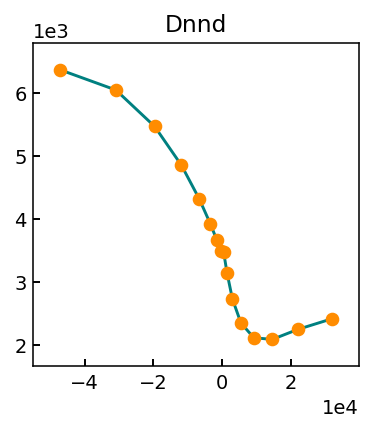

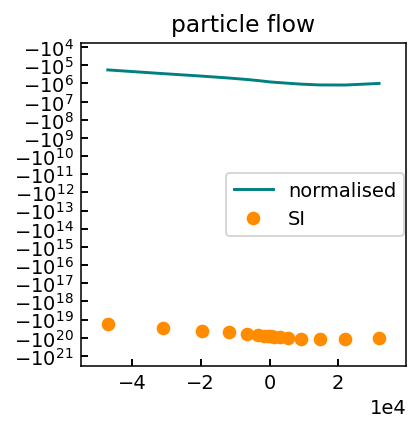

In [13]:
dfs = {}

for case in ["si", "base"]:
    
    ds = cs[case].ds
    if "t" in ds.sizes: ds = ds.isel(t=-1)

    hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "g22", "g_33", "Nd", "Ne", "Pd", "Dnnd", "Td", "particle_flux_factor_d", "Vd_perp_x"], "omp")
    
    m = ds.metadata
    Dnnorm = m["Cs0"] * m["Cs0"] / m["Omega_ci"]
    Pnorm = ds.metadata["Nnorm"] * ds.metadata["Tnorm"] * constants("q_e")

    hrdf["dpol"] = hrdf["dy"] * np.sqrt(hrdf["g22"])
    hrdf["dtor"] = hrdf["dz"] * np.sqrt(hrdf["g_33"])
    hrdf["da_radial"] = hrdf["dpol"] * hrdf["dtor"]

    pn_floor = 1e-8 * 1/100 * Pnorm
    hrdf["Pnlim"] = np.clip(hrdf["Pd"], pn_floor, None)

    hrdf["flux_hermes"] = hrdf["ParticleFlow_d_xlow"] /  hrdf["da_radial"] * hrdf["particle_flux_factor_d"]
    hrdf["V_from_flux"] = hrdf["flux_hermes"] / hrdf["Nd"] 
    
    dfs[case] = hrdf.copy()
    
fig, ax = plt.subplots(figsize = (3,3))
ax.set_title("Dnnd")
ax.plot(dfs["base"]["Srad"], dfs["base"]["Dnnd"] * Dnnorm, label = "normalised")
ax.plot(dfs["base"]["Srad"], dfs["si"]["Dnnd"], "o", label = "SI")

fig, ax = plt.subplots(figsize = (3,3))
ax.set_title("particle flow")
ax.plot(dfs["base"]["Srad"], dfs["base"]["ParticleFlow_d_xlow"] * Dnnorm, label = "normalised")
ax.plot(dfs["base"]["Srad"], dfs["si"]["ParticleFlow_d_xlow"], "o", label = "SI")
ax.legend()
ax.set_yscale("symlog")

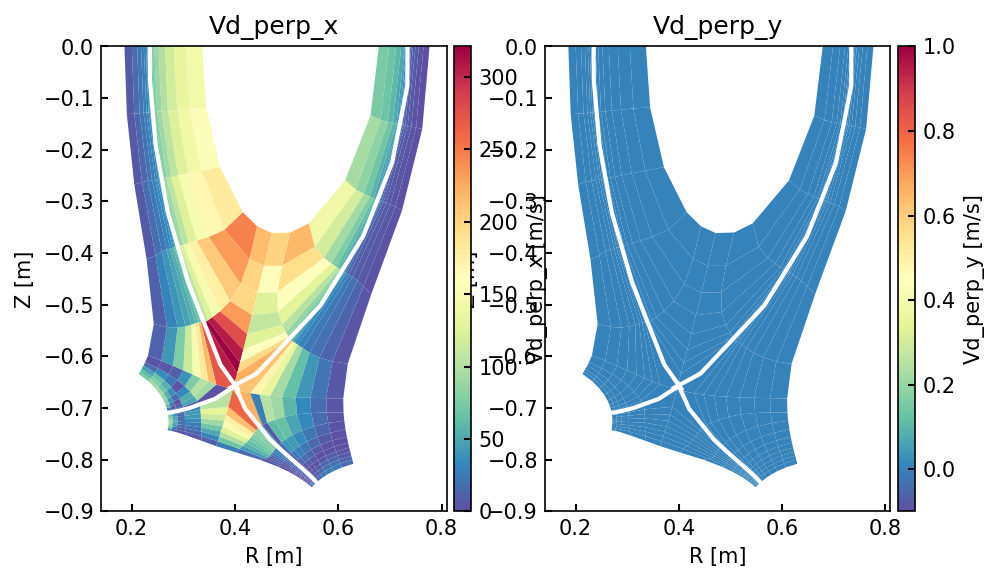

In [ ]:
cmap = "Spectral_r"

fig, axes = plt.subplots(1,2, figsize = (7,4.5), dpi = 150)

data = abs(cs["base"].ds["Vd_perp_x"])
data.hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = cmap, targets = False, 
                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                       antialias = True,
                                                       logscale = False,
                                                       vmin = np.nanmin(data.values), vmax = np.nanmax(data.values),
                                                      #  vmin = -1, vmax = 1,
                                                       
                                                       )
data = abs(cs["base"].ds["Vd_perp_y"])
data.hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = cmap, targets = False, 
                                                       separatrix_kwargs = dict(color="white", linestyle = "-", linewidth = 2),
                                                       antialias = True,
                                                       logscale = False,
                                                       vmin = np.nanmin(data.values)+1, vmax = np.nanmax(data.values),
                                                      #  vmin = -1, vmax = 1,
                                                       
                                                       )

# axes[0].set_title("Vd_perp_x")
# axes[1].set_title("Test: suppress core rad")
for ax in axes:
    ax.set_ylim(-0.9, 0)


In [4]:
ds = cs["base"].ds
hrdf = get_1d_radial_data(ds, ["ParticleFlow_d_xlow", "dy", "dz", "Nd", "Pd", "Dnnd", "Td", "particle_flux_factor_d", "Vd_perp_x"], "omp")

hrdf["flux_hermes"] = hrdf["ParticleFlow_d_xlow"] /  (hrdf["dy"]*hrdf["dz"]) * hrdf["particle_flux_factor_d"]
hrdf["V_hermes"] = hrdf["flux_hermes"] / hrdf["Nd"] / hrdf["particle_flux_factor_d"]

hrdf["Grad_Pa_hermes"] = np.gradient(hrdf["Pd"], hrdf["Srad"])
hrdf["V_hermes_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"]
hrdf["V_hermes_fluxlim_reconstruct"] = -hrdf["Dnnd"] * hrdf["Grad_Pa_hermes"] / hrdf["Pd"] * hrdf["particle_flux_factor_d"]

# hrdf["vth"] = 0.25 * np.sqrt(8 * (hrdf["Td"]*constants("q_e")) / (np.pi * 2*constants("mass_p")))

fig, axes =plt.subplots(1,3, figsize = (9,3))
ax = axes[0]
ax.set_title("Velocities")
ax.plot(hrdf["Srad"], abs(hrdf["V_hermes"]), label = "Simulation from flux")
ax.plot(hrdf["Srad"], abs(hrdf["Vd_perp_x"]), label = "Simulation from velocity")
ax.plot(hrdf["Srad"], hrdf["vth"], label = "Thermal speed")
# ax.plot(hrdf["Srad"], hrdf["V_hermes_reconstruct"], label = "Reconstructed")
# ax.plot(hrdf["Srad"], hrdf["V_hermes_fluxlim_reconstruct"], label = "Reconstructed w. flux lim")
ax.legend(fontsize = "x-small")

ValueError: setting an array element with a sequence.